In [1]:
import math
import matplotlib
import json
import requests
import time
import numpy as np
import pandas as pd
import seaborn as sns
import misc_function as mf
import matplotlib.dates as dates

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [3]:
pd.options.mode.chained_assignment = None # turn off warning message

In [4]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['Close'])):
        X_train = np.array(range(len(df['Close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['Close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1) # reshape array
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict([[N]])
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

In [5]:
#request api of current daily stock of selected symbol
funct = "history"
sym = "AAPL"
fromdt = "2015-01-01"
req_url = mf.stock_url(funct, sym, fromdt)
print(req_url)

https://api.worldtradingdata.com/api/v1/history?symbol=AAPL&date_from=2015-01-01&sort=newest&api_token=YFl1bfK9zAddFzcsOgenstMkFg3Vl84lb6rtf80vAbQ2yj1ldqM4lv75cE5q


In [6]:
#convert response to python json list
data = requests.get(req_url).json()[funct]

In [7]:
df = pd.DataFrame(data)
df = df.T

In [8]:
df.tail()

,open,close,high,low,volume
2015-01-08,109.23,111.89,112.15,108.70,59364547
2015-01-07,107.20,107.75,108.20,106.70,40105934
2015-01-06,106.54,106.26,107.43,104.63,65797116
2015-01-05,108.29,106.25,108.65,105.41,64285491
2015-01-02,111.39,109.33,111.44,107.35,53204626


In [9]:
#convert list to dataframe
df = pd.DataFrame(columns=['Date','Open','High','Low','Close'])
for k,v in data.items():
    date = datetime.strptime(k, '%Y-%m-%d')
    data_row = [date.date(),float(v['open']),float(v['high']),
                float(v['low']),float(v['close'])]
    df.loc[-1,:] = data_row
    df.index = df.index + 1

In [10]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [11]:
dfCopy = df.copy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


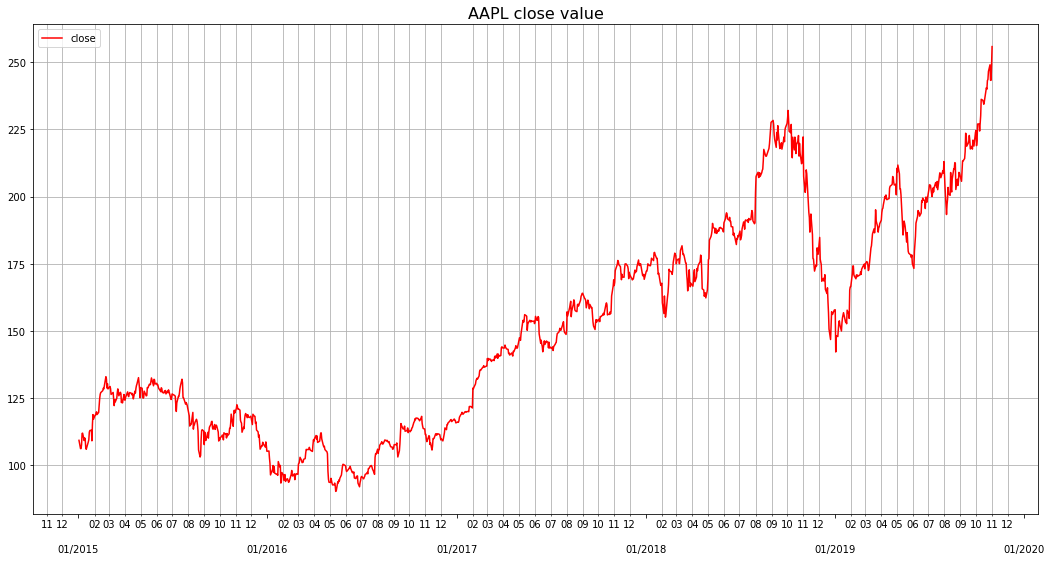

In [12]:
#df = df.astype(float)
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_title(f'{sym} close value', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.plot_date(dfCopy['Date'], dfCopy['Close'], 'r-', label='close')
#ax.plot_date(df['Date'], df['Close'], 'b-', label='CLOSE')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%m/%Y'))
plt.legend(loc=2)
#plt.tight_layout()
plt.show()

In [13]:
smaFast = 10
smaSlow = 20
dfCopy['fastMA'] = dfCopy.Close.rolling(window=smaFast).mean()
dfCopy['slowMA'] = dfCopy.Close.rolling(window=smaSlow).mean()

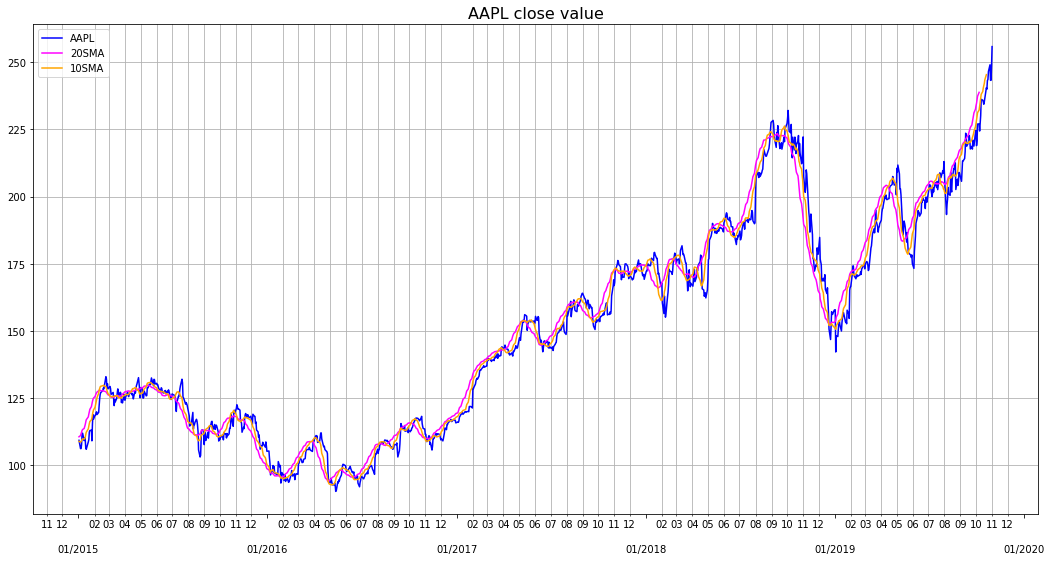

In [14]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_title(f'{sym} close value', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.plot_date(dfCopy['Date'], dfCopy['Close'], '-', label=sym, color='blue')
ax.plot_date(dfCopy['Date'], dfCopy['slowMA'], '-', label='20SMA', color='magenta')
ax.plot_date(dfCopy['Date'], dfCopy['fastMA'], '-', label='10SMA', color='orange')
#ax.plot_date(df['Date'], df['Close'], 'b-', label='CLOSE')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%m/%Y'))
plt.legend(loc=2)
#plt.tight_layout()
plt.show()

### Linear Regression Method

In [15]:
df = df.sort_index()
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 732
num_cv = 243
num_test = 243
train.shape = (732, 5)
cv.shape = (243, 5)
train_cv.shape = (975, 5)
test.shape = (243, 5)


Text(0, 0.5, 'Price')

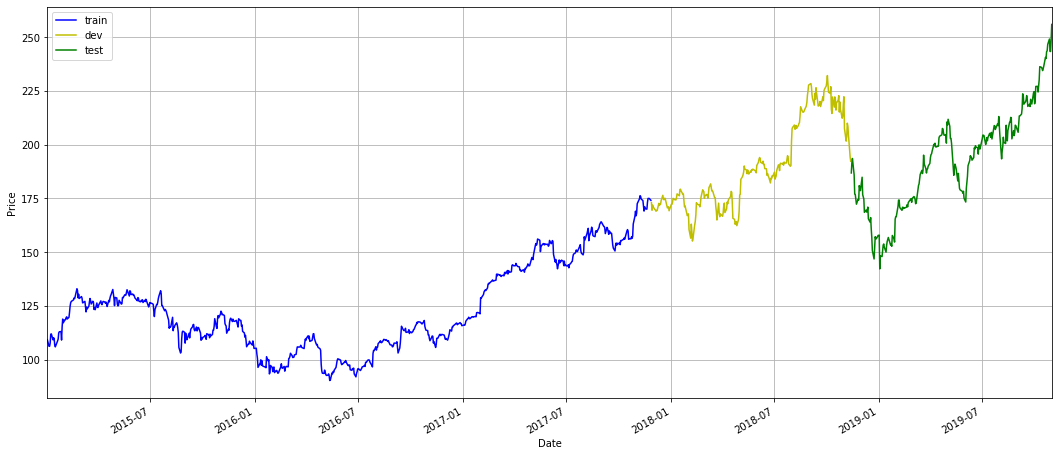

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")

In [17]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'Close', N, 0, num_train)
    
    cv['est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['Close'])))
    R2.append(r2_score(cv['Close'], est_list))
    mape.append(mf.get_mape(cv['Close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [3.0647275135826173, 4.227872145732233, 3.942225759830651, 3.8949080930745934, 3.8501474826115545, 3.849092020557064, 3.886504863682737, 3.910866358691897, 4.064378940816689, 4.258272255366375, 4.429648154896649, 4.587995790721667, 4.74072381212906, 4.88724864032096, 5.023127417222596, 5.1870359013231475, 5.346518156946941, 5.470219831422677, 5.558661254450521, 5.636069854961569, 5.701616184805646, 5.748005545047648, 5.782130926296023, 5.796934264787752, 5.815082520307303, 5.844069325435133, 5.876065048388051, 5.913278057498799, 5.955511234849311, 6.008631657149065]
R2 = [0.9767679640937553, 0.9557872807377181, 0.9615597221038598, 0.9624769645025534, 0.9633344446524388, 0.9633545445567423, 0.9626387010688296, 0.9621688549073897, 0.9591406060482699, 0.9551491802110104, 0.9514664566794707, 0.947934558271883, 0.9444104901025796, 0.9409210994319092, 0.9375903244095987, 0.9334509219011683, 0.929295732412935, 0.9259861330504344, 0.923573503117482, 0.9214300873649445, 0.919591956864910

,Date,Open,High,Low,Close,est_N1,est_N2,est_N3,est_N4,est_N5,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
732,2017-11-28,174.3,174.87,171.86,173.07,174.09,173.21,173.803333,175.005,176.443,...,175.002810,175.995065,176.832174,177.401304,177.8880,178.228338,178.476610,178.360556,178.165443,177.994552
733,2017-11-29,172.63,172.92,167.16,169.48,173.07,172.05,172.143333,172.635,173.743,...,174.327238,174.954935,175.919328,176.742754,177.3142,177.808831,178.164017,178.430714,178.345296,178.181011
734,2017-11-30,170.43,172.14,168.44,171.85,169.48,165.89,167.603333,168.530,169.456,...,173.226667,173.644675,174.283399,175.247283,176.0807,176.674862,177.195812,177.582381,177.882660,177.841241
735,2017-12-01,169.95,171.67,168.5,171.05,171.85,174.22,170.246667,169.545,169.437,...,172.792190,173.063117,173.473834,174.098949,175.0405,175.862769,176.459031,176.986905,177.386478,177.703103
736,2017-12-04,172.48,172.62,169.63,169.8,171.05,170.25,172.363333,170.440,169.718,...,171.929714,172.510519,172.783439,173.191630,173.8079,174.732000,175.546553,176.146984,176.683300,177.096851


(2, 30)

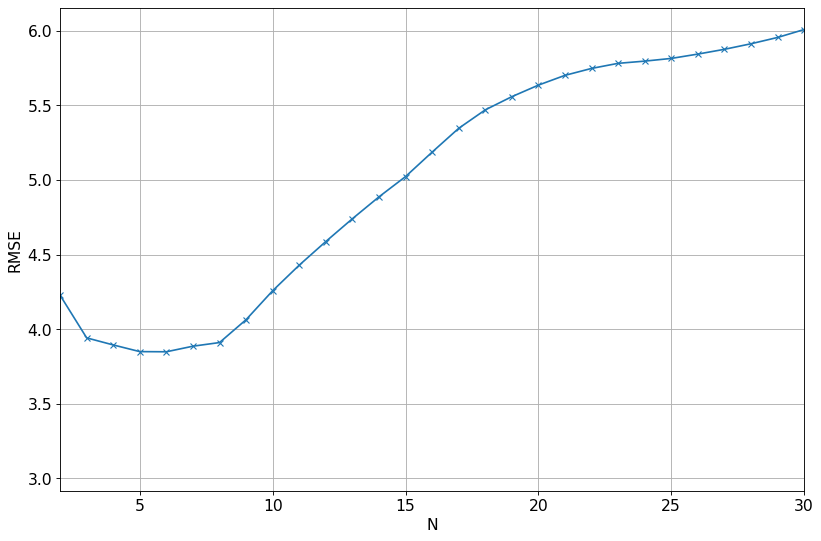

In [18]:
# Plot RMSE versus N
rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Text(0, 0.5, 'R2')

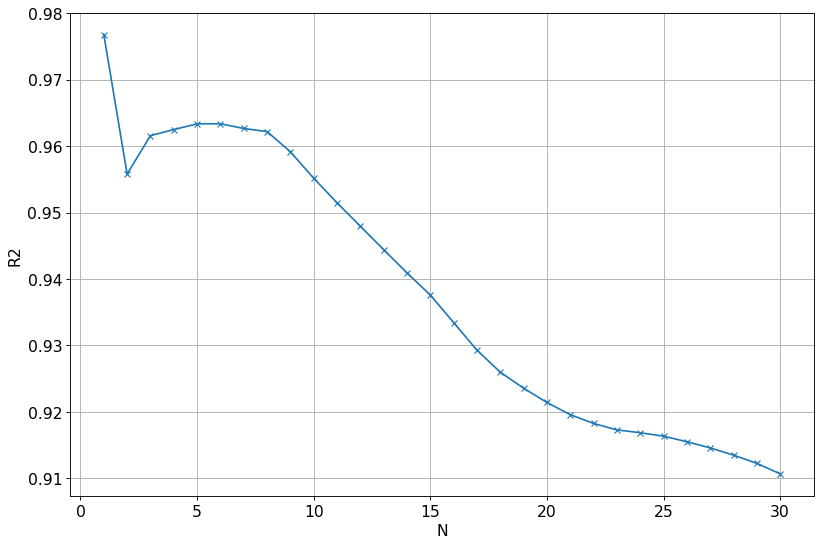

In [19]:
# Plot R2 versus N. Note for R2 larger better. 
rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

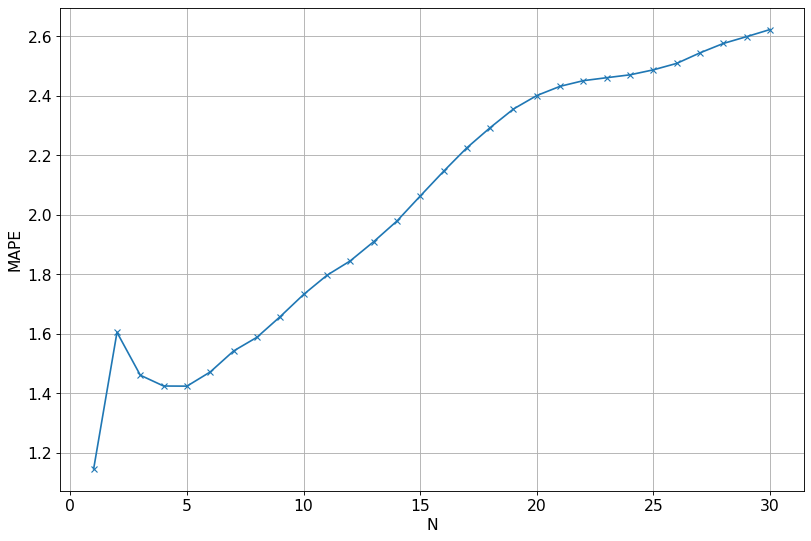

In [20]:

# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [21]:
from datetime import date, datetime, time, timedelta

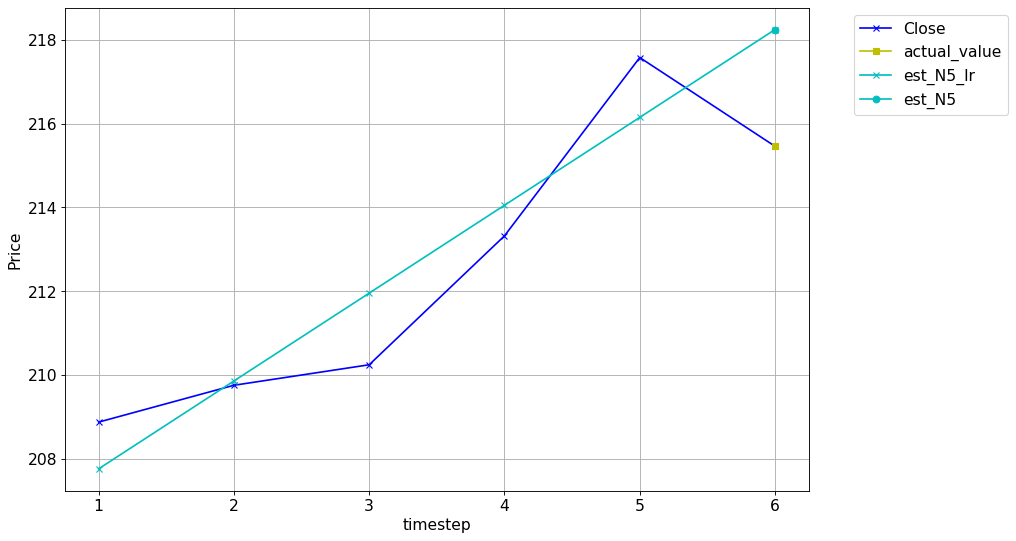

In [22]:
# Specify the day you are interested in
day = pd.Timestamp(date(2018, 8, 20))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['Date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['Close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['Close'], 'ys-')
legend_list = ['Close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['Close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['Close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('Price')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

Text(0.5, 1.0, 'Zoom in to dev set')

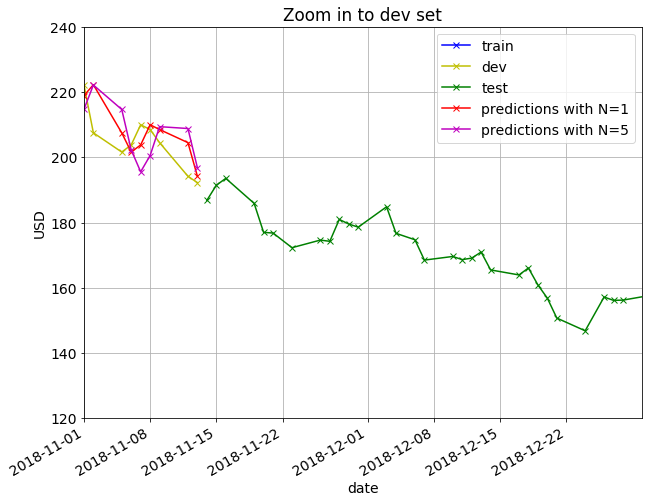

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 11, 1), date(2018, 12, 30)])
ax.set_ylim([120, 240])
ax.set_title('Zoom in to dev set')

In [24]:
optN = 1

In [25]:
est_list = get_preds_lin_reg(df, 'Close', optN, 0, num_train+num_cv)
test['est' + '_N' + str(optN)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['Close'])))
print("R2 = %0.3f" % r2_score(test['Close'], est_list))
print("MAPE = %0.3f%%" % mf.get_mape(test['Close'], est_list))
test.head()

RMSE = 3.533
R2 = 0.978
MAPE = 1.354%


,Date,Open,High,Low,Close,est_N1
975,2018-11-14,193.9,194.48,185.93,186.8,192.23
976,2018-11-15,188.39,191.97,186.9,191.41,186.80
977,2018-11-16,190.5,194.97,189.46,193.53,191.41
978,2018-11-19,190,190.7,184.99,185.86,193.53
979,2018-11-20,178.37,181.47,175.51,176.98,185.86


Text(0, 0.5, 'USD')

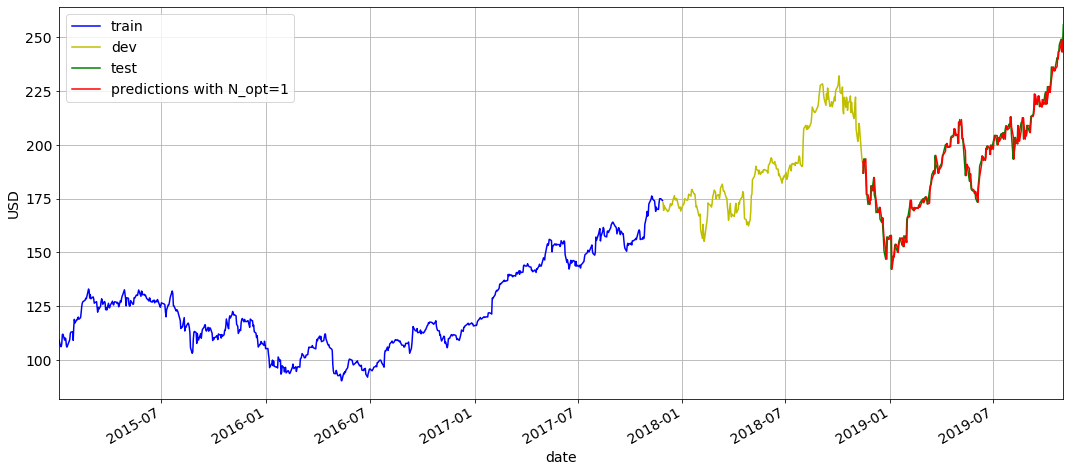

In [26]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train.plot(x='Date', y='Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

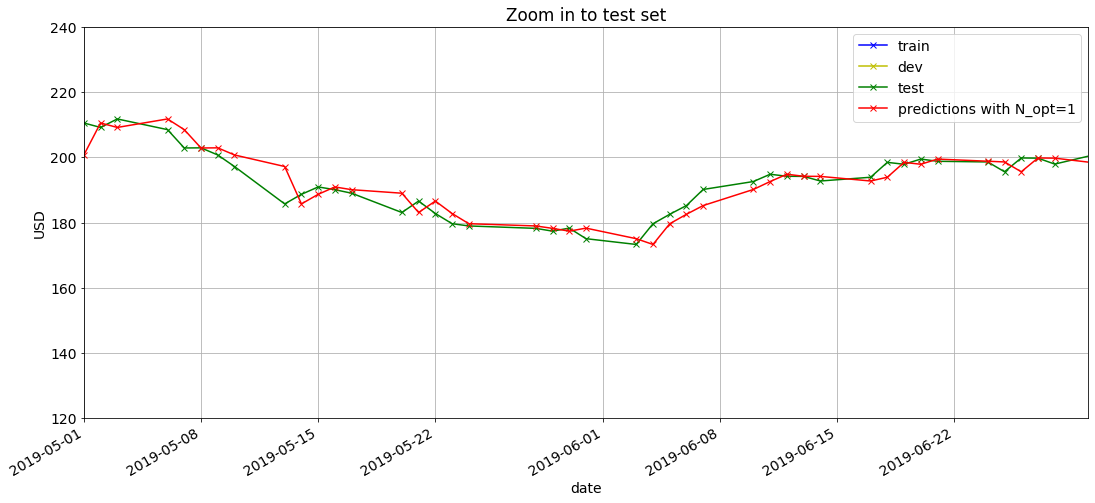

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train.plot(x='Date', y='Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 5, 1), date(2019, 6, 30)])
ax.set_ylim([120, 240])
ax.set_title('Zoom in to test set')

(120, 240)

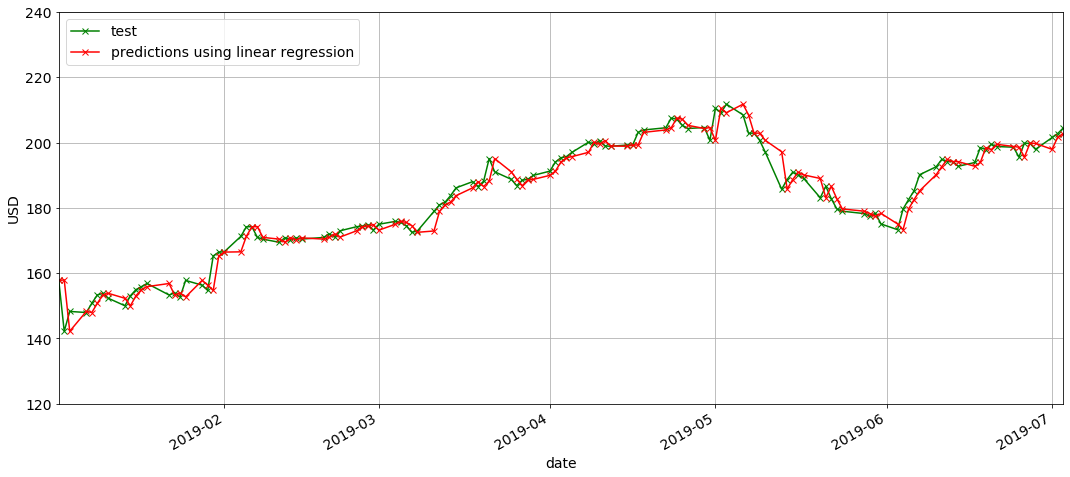

In [28]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 18, 8 # width 10, height 8
rcParams.update({'font.size': 14})

ax = test.plot(x='Date', y='Close', style='gx-', grid=True)
ax = test.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 1, 2), date(2019, 7, 3)])
ax.set_ylim([120, 240])

In [29]:
test.tail()

,Date,Open,High,Low,Close,est_N1
1213,2019-10-28,247.42,249.25,246.72,249.05,246.58
1214,2019-10-29,248.97,249.75,242.57,243.29,249.05
1215,2019-10-30,244.76,245.3,241.21,243.26,243.29
1216,2019-10-31,247.24,249.17,237.26,248.76,243.26
1217,2019-11-01,249.54,255.93,249.16,255.82,248.76
